In [1]:
import numpy as np
import matplotlib.pyplot as plt
from glob import glob
from os.path import join
from os.path import splitext
import cv2
import os
from tqdm import tqdm
from shapely.geometry import Point
from shapely.geometry.polygon import Polygon
import xml.etree.ElementTree as ET

In [2]:
aperios = glob(join('datasets', 'aperio', '*'))
camms = glob(join('datasets', 'camm', '*'))
annotations = glob(join('annotations', '*'))

In [3]:
# read the image files
def register(img_path_moving, img_path_fixed):
    img1_color = cv2.imread(img_path_moving)  # moving
    img2_color = cv2.imread(img_path_fixed)    # fixed

    # resize the image
    h_aperio, w_aperio = img1_color.shape[:2]
    h_camm, w_camm = img2_color.shape[:2]

    x_scale = w_camm/w_aperio
    y_scale = h_camm/h_aperio

    img1_color = cv2.resize(img1_color, (w_camm, h_camm))


    # Convert to grayscale
    img1 = cv2.cvtColor(img1_color, cv2.COLOR_BGR2GRAY)
    img2 = cv2.cvtColor(img2_color, cv2.COLOR_BGR2GRAY)
    height, width = img2.shape

    # Create ORB detector with 5000 features.
    orb_detector = cv2.ORB_create(5000)

    # Find keypoints and descriptors.
    # The first arg is the image, second arg is the mask
    #  (which is not required in this case).
    kp1, d1 = orb_detector.detectAndCompute(img1, None)
    kp2, d2 = orb_detector.detectAndCompute(img2, None)

    # Match features between the two images.
    # We create a Brute Force matcher with
    # Hamming distance as measurement mode.
    matcher = cv2.BFMatcher(cv2.NORM_HAMMING, crossCheck = True)

    # Match the two sets of descriptors.
    matches = matcher.match(d1, d2)

    # Sort matches on the basis of their Hamming distance.
    matches.sort(key = lambda x: x.distance)

    # Take the top 90 % matches forward.
    matches = matches[:int(len(matches)*0.9)]
    no_of_matches = len(matches)

    # Define empty matrices of shape no_of_matches * 2.
    p1 = np.zeros((no_of_matches, 2))
    p2 = np.zeros((no_of_matches, 2))

    for i in range(len(matches)):
        p1[i, :] = kp1[matches[i].queryIdx].pt
        p2[i, :] = kp2[matches[i].trainIdx].pt


    homography, mask = cv2.findHomography(p1, p2, cv2.RANSAC)
    transformed_img = cv2.warpPerspective(img1_color,
                        homography, (width, height))
    cv2.imwrite(join('processed', aperio.split(os.sep)[-1]), transformed_img)
    with open(join('processed', splitext(aperio.split(os.sep)[-1])[0]+'.npy'), 'wb') as f:
        np.save(f, homography)
        
    return homography, x_scale, y_scale

fix 475 372  
mov 990 800

In [4]:
mov = [990*x_scale, 800*y_scale, 1]
homography @ mov

NameError: name 'x_scale' is not defined

In [5]:
def transform_polygons(xml_path, tfm, scale=(1/32, 1, 1)):
    tree = ET.parse(xml_path)
    root = tree.getroot()
    annotations = root.findall('Annotation/Regions/Region')
    polygons = []
    t_polygons = []
    for annotation in annotations:
        coords = annotation.findall('Vertices/Vertex')
        polygon = []
        t_polygon = []
        for coord in coords:
            x = float(coord.attrib['X'])
            y = float(coord.attrib['Y'])
            mov = [x*scale[0]*scale[1], y*scale[0]*scale[2], 1]
            t_mov = tfm @ mov
            t_x = int(np.round((t_mov[0]-1)/scale[0]))
            t_y = int(np.round((t_mov[1]-1)/scale[0]))
            polygon.append((int(np.round(x)), int(np.round(y))))
            t_polygon.append((t_x, t_y))
            coord.set('X', str(t_x))
            coord.set('Y', str(t_y))
        polygons.append(polygon)
        t_polygons.append(t_polygon)
    tree.write(join('processed', xml_path.split(os.sep)[-1]))
    return polygons, t_polygons

In [6]:
for aperio, camm, annotation in zip(aperios, camms, annotations):
    tfm, x_scale, y_scale = register(aperio, camm)
    transform_polygons(annotation, tfm, (1/32, x_scale, y_scale))

error: OpenCV(4.5.3) D:\bld\libopencv_1633801008259\work\modules\imgcodecs\src\loadsave.cpp:77: error: (-215:Assertion failed) pixels <= CV_IO_MAX_IMAGE_PIXELS in function 'cv::validateInputImageSize'


In [7]:
class AnnotationTranslator:
    def __init__(self, aperios, camms, annotations, down_factor=32):
        self.aperios = aperios
        self.camms = camms
        self.annotations = annotations
        self.scale = 1/down_factor
        
    def update_aperios(self, aperios):
        self.aperios = aperios
    
    def update_camms(self, camms):
        self.camms = camms
        
    def update_annotations(self, annotations):
        self.annotations = annotations
        
    def transform_polygons(xml_path, tfm, scale=(1/32, 1, 1)):
        tree = ET.parse(xml_path)
        root = tree.getroot()
        annotations = root.findall('Annotation/Regions/Region')
        polygons = []
        t_polygons = []
        for annotation in annotations:
            coords = annotation.findall('Vertices/Vertex')
            polygon = []
            t_polygon = []
            for coord in coords:
                x = float(coord.attrib['X'])
                y = float(coord.attrib['Y'])
                mov = [x*scale[0]*scale[1], y*scale[0]*scale[2], 1]
                t_mov = tfm @ mov
                t_x = int(np.round((t_mov[0]-1)/scale[0]))
                t_y = int(np.round((t_mov[1]-1)/scale[0]))
                polygon.append((int(np.round(x)), int(np.round(y))))
                t_polygon.append((t_x, t_y))
                coord.set('X', str(t_x))
                coord.set('Y', str(t_y))
            polygons.append(polygon)
            t_polygons.append(t_polygon)
        tree.write(join('processed', xml_path.split(os.sep)[-1]))
        return polygons, t_polygons
    
    def register(img_path_moving, img_path_fixed):
        img1_color = cv2.imread(img_path_moving)  # moving
        img2_color = cv2.imread(img_path_fixed)   # fixed

        # resize the image
        h_aperio, w_aperio = img1_color.shape[:2]
        h_camm, w_camm = img2_color.shape[:2]

        x_scale = w_camm/w_aperio
        y_scale = h_camm/h_aperio

        img1_color = cv2.resize(img1_color, (w_camm, h_camm))


        # Convert to grayscale
        img1 = cv2.cvtColor(img1_color, cv2.COLOR_BGR2GRAY)
        img2 = cv2.cvtColor(img2_color, cv2.COLOR_BGR2GRAY)
        height, width = img2.shape

        # Create ORB detector with 5000 features.
        orb_detector = cv2.ORB_create(5000)

        # Find keypoints and descriptors.
        # The first arg is the image, second arg is the mask
        #  (which is not required in this case).
        kp1, d1 = orb_detector.detectAndCompute(img1, None)
        kp2, d2 = orb_detector.detectAndCompute(img2, None)

        # Match features between the two images.
        # We create a Brute Force matcher with
        # Hamming distance as measurement mode.
        matcher = cv2.BFMatcher(cv2.NORM_HAMMING, crossCheck = True)

        # Match the two sets of descriptors.
        matches = matcher.match(d1, d2)

        # Sort matches on the basis of their Hamming distance.
        matches.sort(key = lambda x: x.distance)

        # Take the top 90 % matches forward.
        matches = matches[:int(len(matches)*0.9)]
        no_of_matches = len(matches)

        # Define empty matrices of shape no_of_matches * 2.
        p1 = np.zeros((no_of_matches, 2))
        p2 = np.zeros((no_of_matches, 2))

        for i in range(len(matches)):
            p1[i, :] = kp1[matches[i].queryIdx].pt
            p2[i, :] = kp2[matches[i].trainIdx].pt


        homography, mask = cv2.findHomography(p1, p2, cv2.RANSAC)
        transformed_img = cv2.warpPerspective(img1_color,
                            homography, (width, height))
        
        cv2.imwrite(join('processed', img_name+'.tiff'), transformed_img)
        with open(join('processed', img_name+'.npy'), 'wb') as f:
            np.save(f, homography)

        return homography, x_scale, y_scale
    
    def translate(self, get_polygons=False, trust_order=False):
        aperios = self.aperios
        camms = self.camms
        annotations = self.annotations
        returns = {}
        for aperio, camm, annotation in tqdm(zip(aperios, camms, annotations), total=len(aperios)):
            if not trust_order:
                if not (splitext(aperio.split(os.sep)[-1])[0] == splitext(camm.split(os.sep)[-1])[0] == splitext(annotation.split(os.sep)[-1])[0]):
                    raise ValueError('File names do not match!')
                img_name = splitext(aperio.split(os.sep)[-1])[0]
            else:
                if not (len(aperios) == len(camms) == len(annotations)):
                    raise ValueError('Numbers of files do not match!')
                img_name = splitext(aperio.split(os.sep)[-1])[0]
            tfm, x_scale, y_scale = register(aperio, camm)
            polygons, t_polygons = transform_polygons(annotation, tfm, (self.scale, x_scale, y_scale))
            returns[img_name] = ((polygons, t_polygons))
        if get_polygons:
            return returns

In [214]:
aperios = glob(join('datasets', 'aperio', '*'))
camms = glob(join('datasets', 'camm', '*'))
annotations = glob(join('annotations', '*'))

In [215]:
translator = AnnotationTranslator(aperios, camms, annotations, down_factor=32)

In [217]:
translator.translate(get_polygons=False, trust_order=True)

100%|████████████████████████████████████████████████████████████████████████████████████| 6/6 [00:00<00:00,  7.17it/s]


In [1]:
from glob import glob
from os.path import join
from annotation_translator import AnnotationTranslator

In [2]:
aperios = glob(join('datasets', 'aperio', '*'))
camms = glob(join('datasets', 'camm', '*'))
annotations = glob(join('annotations', '*'))

In [3]:
translator = AnnotationTranslator(aperios, camms, annotations, import os
=32)

In [4]:
translator.translate()

100%|████████████████████████████████████████████████████████████████████████████████████| 6/6 [00:00<00:00,  6.85it/s]


In [ ]:
AnnotationTranslator(

In [1]:
import torch
import torch.nn.functional as F
from skimage import io, transform, img_as_float, color, img_as_ubyte, exposure
from skimage.util import view_as_windows, pad
import os
import numpy as np
from models import stylegan, constant_encoder, models, backbones

In [2]:
device = 'cuda:0'

In [3]:
latent_bank = stylegan.StyledGenerator().to(device)
encoder = constant_encoder.Encoder().to(device)
decoder = constant_encoder.Decoder().to(device)
generator = models.EDLatentBank(encoder, decoder, latent_bank).to(device)

In [4]:
generator_weights = torch.load('model_weights/bf-enhancer.pth')
generator.load_state_dict(generator_weights, strict=False)

<All keys matched successfully>

In [5]:
class BFEnhancer:
    
    def __init__(self, config):
        self.config = config
        if config['bf-enhencment'] == True:
            latent_bank = stylegan.StyledGenerator()
            encoder = constant_encoder.Encoder()
            decoder = constant_encoder.Decoder()
            generator = models.EDLatentBank(encoder, decoder, latent_bank)
            generator_weights = torch.load('model_weights/bf-enhancer.pth')
            generator.load_state_dict(generator_weights, strict=False)
        generator.eval()
        if config['gpu'] == True:
            self.model = generator.cuda()
        else:
            self.model = generator
            
        self.bf_ppm = config['pixel-size-bf-4x'] # 1.105
        self.ap_ppm = 0.5039
        self.patch_size = (256, 256, 3)
            
    def compute(self, image, overlap=32, mode=0):
        bf_ppm = self.bf_ppm
        ap_ppm = self.ap_ppm
        patch_size = self.patch_size
        device = next(self.model.parameters()).device
        with torch.no_grad():
            image = img_as_float(image)
            width = image.shape[1]
            height = image.shape[0]
            step_size = patch_size[0]-32
            image = transform.resize(image, (int(height * bf_ppm / ap_ppm), int(width * bf_ppm / ap_ppm)), order=1) # resize image to match input resolution
            pad_h = int((np.floor(image.shape[0]/step_size) * step_size + patch_size[0]) - image.shape[0])
            pad_w = int((np.floor(image.shape[1]/step_size) * step_size + patch_size[1]) - image.shape[1])
            image_pad = np.pad(image, ((0, pad_h), (0, pad_w), (0, 0)), mode='reflect')
            patches = view_as_windows(image_pad, patch_size, step=step_size).squeeze() # row x col x H x W x C
            
            cols = patches.shape[1]
            rows = patches.shape[0]
            batches = torch.from_numpy(patches.transpose(0, 1, 4, 2, 3)) # row x col x C x H x W
            outputs = []
            for batch in batches:
                batch = batch.float().to(device) # col x C x H x W
                output = self.model(batch)
                output = np.clip(output.cpu().numpy(), 0, 1)
                output = output.transpose(0, 2, 3, 1) # col x H x W x C
                outputs.extend(output)
            outputs = np.stack(outputs, axis=0)
            
            outputs = outputs.reshape(rows, cols, patch_size[0], patch_size[1], patch_size[2])
            canvas_size = (image_pad.shape[0], image_pad.shape[1], 3)
            canvas = np.zeros(canvas_size)
            decay = np.linspace(1, 0, overlap)
            grow = np.linspace(0, 1, overlap)
            mask_left = np.ones(patch_size)
            mask_top = np.ones(patch_size)
            mask_right = np.ones(patch_size)
            mask_bottom = np.ones(patch_size)
            mask_left[:, 0:overlap] = np.repeat(np.repeat(grow.reshape(1, -1), patch_size[0], axis=0).reshape(patch_size[0], -1, 1), patch_size[2], 2)
            mask_top[0:overlap, :] = np.repeat(np.repeat(grow.reshape(-1, 1), patch_size[1], axis=1).reshape(-1, patch_size[1], 1), patch_size[2], 2)
            mask_right[:, -overlap:] = np.repeat(np.repeat(decay.reshape(1, -1), patch_size[0], axis=0).reshape(patch_size[0], -1, 1), patch_size[2], 2)
            mask_bottom[-overlap:, :] = np.repeat(np.repeat(decay.reshape(-1, 1), patch_size[1], axis=1).reshape(-1, patch_size[1], 1), patch_size[2], 2)
            for id_y in range(rows):
                for id_x in range(cols):
                    mask = np.ones(patch_size)
                    cursor_x = id_x * step_size
                    cursor_y = id_y * step_size
                    if id_x != 0:
                        mask = mask * mask_left
                    if id_x != (cols-1):
                        mask = mask * mask_right
                    if id_y != 0:
                        mask = mask * mask_top
                    if id_y != (rows-1):
                        mask = mask * mask_bottom
                    paint = np.zeros(canvas_size)
                    paint[cursor_y:cursor_y+patch_size[0], cursor_x:cursor_x+patch_size[1], :] = outputs[id_y, id_x] * mask
                    canvas = canvas + paint
            
            if mode == 0:
                predicted = transform.resize(canvas[:image.shape[0], :image.shape[1]], (height, width), order=1, anti_aliasing=True)
            elif mode == 1:
                predicted = transform.resize(canvas[:image.shape[0], :image.shape[1]], (height*2, width*2), order=1, anti_aliasing=True) 
            elif mode == 2:
                predicted = canvas[:image.shape[0], :image.shape[1]]
        return predicted, outputs

In [3]:
from bf_enhancer import BFEnhancer

In [4]:
config = {
    "bf-enhencment" : True,
    "gpu" : True,
    "pixel-size-bf-4x" : 1.105,  
}

In [5]:
bf_enhancer = BFEnhancer(config)

In [7]:
from skimage import io
img = io.imread('camm_4x/39.tiff')

In [9]:
predicted = bf_enhancer.compute(img)

In [237]:
io.imsave('39-processed-blend.tiff', predicted)

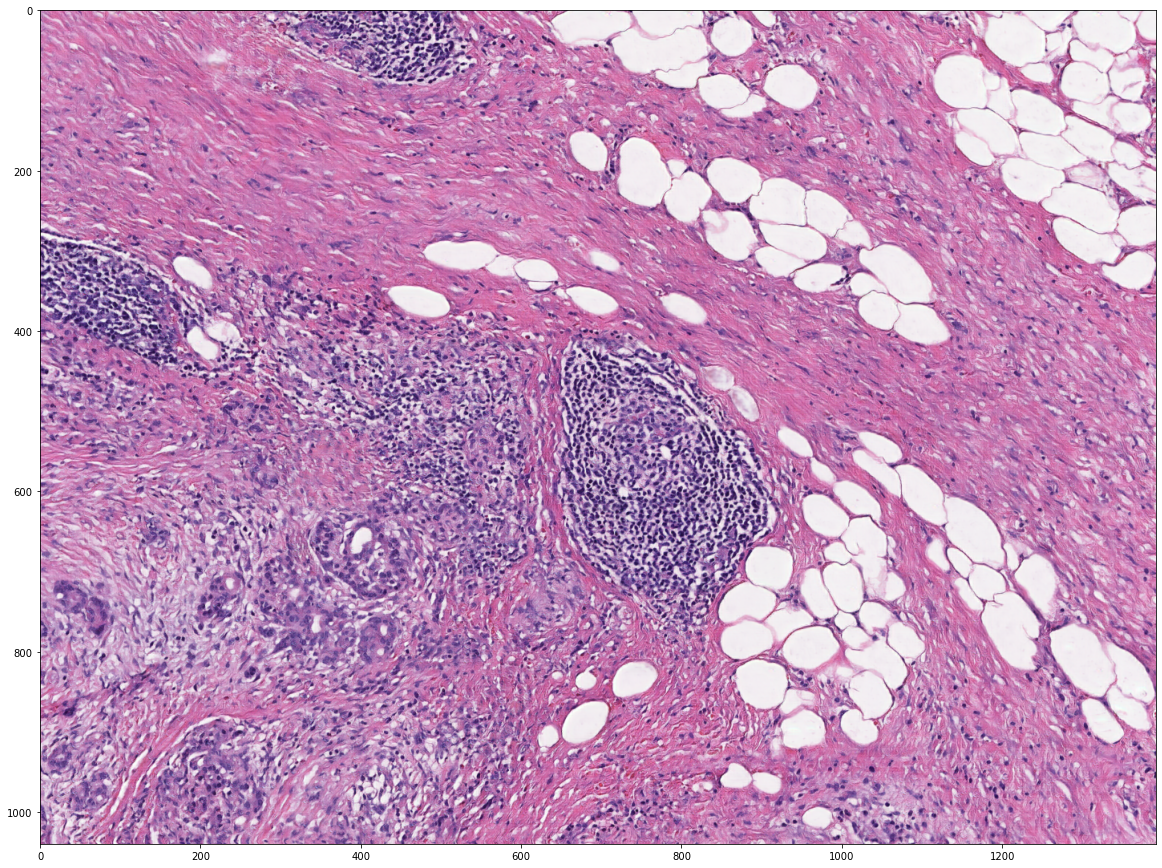

In [13]:
import matplotlib.pyplot as plt
plt.figure(figsize=(20, 40))
imgplot = plt.imshow(predicted)
plt.show()

In [11]:
outputs.shape

(11, 14, 256, 256, 3)

In [13]:
# make canvas
img_size = (256, 256, 3)
canvas_size = (2280, 3052, 3)
overlap = 32
step_size = img_size[1]-32
canvas = np.zeros(canvas_size)
outputs = view_as_windows(canvas, img_size, step=step_size).squeeze()

In [14]:
cols = outputs.shape[1]
rows = outputs.shape[0]

In [ ]:
t = time.time()
canvas = np.zeros(canvas_size)
decay = np.linspace(1, 0, overlap)
grow = np.linspace(0, 1, overlap)
mask_left = np.ones(img_size)
mask_top = np.ones(img_size)
mask_right = np.ones(img_size)
mask_bottom = np.ones(img_size)
mask_left[:, 0:overlap] = np.repeat(np.repeat(grow.reshape(1, -1), img_size[0], axis=0).reshape(img_size[0], -1, 1), img_size[2], 2)
mask_top[0:overlap, :] = np.repeat(np.repeat(grow.reshape(-1, 1), img_size[1], axis=1).reshape(-1, img_size[1], 1), img_size[2], 2)
mask_right[:, -overlap:] = np.repeat(np.repeat(decay.reshape(1, -1), img_size[0], axis=0).reshape(img_size[0], -1, 1), img_size[2], 2)
mask_bottom[-overlap:, :] = np.repeat(np.repeat(decay.reshape(-1, 1), img_size[1], axis=1).reshape(-1, img_size[1], 1), img_size[2], 2)

# for id_y in range(rows):
#     for id_x in range(cols):
#         mask = np.ones(img_size)
#         cursor_x = id_x * step_size
#         cursor_y = id_y * step_size
#         if id_x != 0:
#             mask = mask * mask_left
#         if id_x != (cols-1):
#             mask = mask * mask_right
#         if id_y != 0:
#             mask = mask * mask_top
#         if id_y != (rows-1):
#             mask = mask * mask_bottom
#         paint = np.zeros(canvas_size)
#         paint[cursor_y:cursor_y+img_size[0], cursor_x:cursor_x+img_size[1], :] = outputs[id_y, id_x] * mask
#         canvas = canvas + paint

all_args = []
for id_y in range(rows):
    for id_x in range(cols):
        all_args.append((outputs, (id_x, id_y), cols, rows, img_size, canvas_size, step_size, mask_left, mask_right, mask_top))

# Parallel(n_jobs=2)(delayed(montage)(outputs, coord, cols, rows, img_size, canvas_size, step_size, mask_left, mask_right, mask_top) for coord in coords)
# paint = montage(outputs, coords[0], cols, rows, img_size, canvas_size, step_size, mask_left, mask_right, mask_top)

# call freeze_support() if in Windows
if os.name == "nt":
    freeze_support()
pool = Pool(cpu_count()) 
# results = pool.map(wrap_montage, [item for item in all_args])
results = pool.map(wrap_test, [item for item in (2, 3, 4)])

print(time.time()-t)

In [8]:
import multiprocessing

def getLocalResult(args):
    """ Do whatever you want in this func.  
        The point is that it takes x,i,j and 
        returns localResult
    """
    x,i,j = args  #unpack args
    return doSomething(x,i,j)

def computation(np=4):
    """ np is number of processes to fork """
    p = multiprocessing.Pool(np)
    output = p.map(getLocalResult, [(x,2,5) for x in range(2,5)] )
    return output

In [ ]:
computation()

In [16]:
def wrap_test(args): 
    """
    we need to wrap the call to unpack the parameters 
    we build before as a tuple for being able to use pool.map
    """ 
    num = args
    test(num) 
    
def test(num):
    return num * 2

In [10]:
from multiprocessing import Pool, freeze_support, cpu_count
import os
from joblib import Parallel, delayed
import time
import itertools

In [28]:
def wrap_montage(args): 
    """
    we need to wrap the call to unpack the parameters 
    we build before as a tuple for being able to use pool.map
    """ 
    outputs, coord, cols, rows, img_size, canvas_size, step_size, mask_left, mask_right, mask_top = args
    montage(outputs, coord, cols, rows, img_size, canvas_size, step_size, mask_left, mask_right, mask_top) 
    
def montage(outputs, coord, cols, rows, img_size, canvas_size, step_size, mask_left, mask_right, mask_top):
    id_x = coord[0]
    id_y = coord[1]
    mask = np.ones(img_size)
    cursor_x = id_x * step_size
    cursor_y = id_y * step_size
    if id_x != 0:
        mask = mask * mask_left
    if id_x != (cols-1):
        mask = mask * mask_right
    if id_y != 0:
        mask = mask * mask_top
    if id_y != (rows-1):
        mask = mask * mask_bottom
    paint = np.zeros(canvas_size)
    paint[cursor_y:cursor_y+img_size[0], cursor_x:cursor_x+img_size[1], :] = outputs[id_y, id_x] * mask
#     return paint

In [296]:
import time
from joblib import Parallel, delayed

def countdown(n):
    while n>0:
        n -= 1
    return n


t = time.time()
for _ in range(20):
    print(countdown(10**7), end=" ")
print(time.time() - t)  
# takes ~10.5 seconds on medium sized Macbook Pro


t = time.time()
results = Parallel(n_jobs=2)(delayed(countdown)(10**7) for _ in range(20))
print(results)
print(time.time() - t)
# takes ~6.3 seconds on medium sized Macbook Pro

0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 9.129807472229004
[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
5.558253526687622


In [141]:
mask_left = np.ones(img_size)
mask_top = np.ones(img_size)
mask_right = np.ones(img_size)
mask_bottom = np.ones(img_size)
mask_left[:, 0:overlap] = np.repeat(np.repeat(grow.reshape(1, -1), img_size[0], axis=0).reshape(img_size[0], -1, 1), img_size[2], 2)
mask_top[0:overlap, :] = np.repeat(np.repeat(grow.reshape(-1, 1), img_size[1], axis=1).reshape(-1, img_size[1], 1), img_size[2], 2)
mask_right[:, -overlap:] = np.repeat(np.repeat(decay.reshape(1, -1), img_size[0], axis=0).reshape(img_size[0], -1, 1), img_size[2], 2)
mask_bottom[-overlap:, :] = np.repeat(np.repeat(decay.reshape(-1, 1), img_size[1], axis=1).reshape(-1, img_size[1], 1), img_size[2], 2)
mask = mask_left * mask_top * mask_right * mask_bottom

In [107]:
np.repeat(grow.reshape(-1, 1), img_size[1], axis=1).shape

(32, 256)

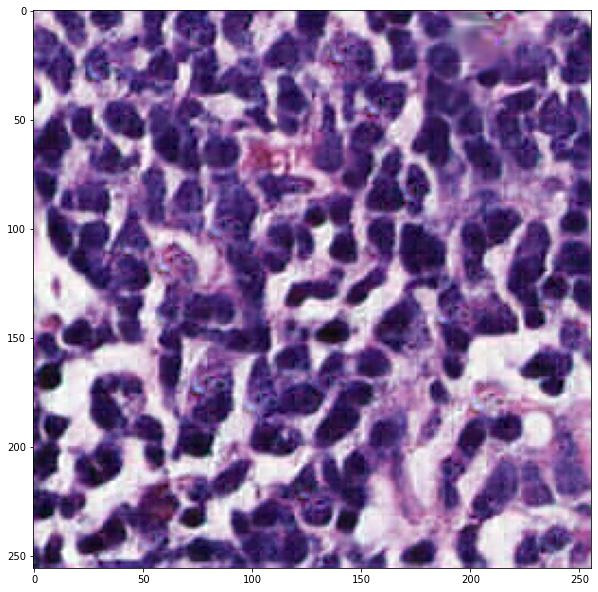

In [241]:
import matplotlib.pyplot as plt
plt.figure(figsize=(10, 20))
imgplot = plt.imshow(canvas)
plt.show()

In [165]:
io.imsave('66-processed-blend.tiff', canvas)

In [2]:
from lsm_enhancer import LSMEnhancer
from bf_enhancer import BFEnhancer

In [ ]:
class SPAcquisition:
    def __init__(self, user_config, model_config, hard_config, mmcore, mmstudio):
        
        config = {**user_config, **model_config, **hard_config}
        print('Load LSM presets.')
        config = self.config_preset(config)
        if config['lsm-enhancer'] is not None:
            print('Configuring LSM enhancer')
            self.lsm_enhancer = LSMEnhancer(config)
        elif config['bf-enhancer'] is not None:
            print('Configuring BF enhancer')
            self.bf_enhancer = BFEnhancer(config)
        
        self.config = config
        self.core = mmcore
        self.studio = mmstudio
        self.last_img = None
        self.bf_4x_bg = None
        self.bf_20x_bg = None
        
            
    def config_preset(self, config):
        if config['exposure-level']=="low":
            config['lsm-scan-rate'] = '500000.0000'
            config['lsm-pc-power'] = 0.3
            config['lsm-pmt-gain'] = 0.35
        if config['exposure-level']=="mid":
            config['lsm-scan-rate'] = '400000.0000'
            config['lsm-pc-power'] = 0.4
            config['lsm-pmt-gain'] = 0.4
        if config['exposure-level']=="high":
            config['lsm-scan-rate'] = '250000.0000'
            config['lsm-pc-power'] = 0.425
            config['lsm-pmt-gain'] = 0.425
        if config['exposure-level']=="extreme":
            config['lsm-scan-rate'] = '200000.0000'
            config['lsm-pc-power'] = 0.45
            config['lsm-pmt-gain'] = 0.45
        config['pixel-size-shg'] = config['pixel-size-shg-base'] * 256 / config["lsm-resolution"]
        return config
    
    
    def update_slide_box(self, box):
        """
            Args: box (tuple): x_start, x_end, y_start, y_end
        """
        assert len(box)==4, "Needs 4 values for the bounding box."
        self.config['slide-box'] = (box[0], box[1], box[2], box[3])
        
        
    def set_bf_4x_focus(self, focus_device):
        """
            Args: focus_device (string): name of the z focus device.
        """
        core = self.core
        config = self.config
        core.set_fucos_device(focus_device)
        config['Z-stage-4x'] = core.get_position()
        aimed_z = config['Z-stage-4x'] + config['Z-bf-offset']
        config['Z-stage-20x'] = limit_stage(aimed_z, (config['hard-limit-z'][0], config['hard-limit-z'][1]), default=config['Z-stage-20x'])
        self.config = config
        
    
    def dump_configuration(self, acq_name, path=None):
        config = self.config
        if path is not None:
            save_path = path    
        else:
            save_path = 'acquisition-configs'
        os.makedirs(save_path, exist_ok=True)
        with open(os.path.join(save_path, acq_name+'.json'), 'w') as fp:
            config_save = copy.deepcopy(config)
            json.dump(config_save, fp)
            
            
    def switch_objective(self, mag='4x'):
        config = self.config
        core = self.core
        if mag == '4x':
            core.set_property('Turret:O:35', 'Label', 'Position-2')
            core.set_focus_device(config['condensor-device'])
            core.set_position(config['F-stage-4x'])
            core.set_focus_device(config['focus-device'])
            focus_z = limit_stage(config['Z-stage-4x'], (config['hard-limit-z'][0], config['hard-limit-z'][1]), default=config['Z-stage-4x'])
            core.set_position(focus_z)
            core.set_property(config['led-device'][0], config['led-device'][1], config['led-4x'])
            core.wait_for_system()
        if mag == '20x':
            core.set_property(config['obj-device'][0], config['obj-device'][1], 'Position-1')
            core.set_focus_device(config['condensor-device'])
            core.set_position(config['F-stage-20x'])
            core.set_focus_device(config['focus-device'])
            focus_z = limit_stage(config['Z-stage-20x'], (config['hard-limit-z'][0], config['hard-limit-z'][1]), default=config['Z-stage-20x'])
            core.set_position(focus_z)
            core.set_property(config['led-device'][0], config['led-device'][1], config['led-20x'])
            core.wait_for_system()
            
            
    def switch_mod(self, mod='shg'):
        core = self.core
        config = self.config
        current_objective = core.get_property('Turret:O:35', 'Label')
        if mod == 'shg':
            if current_objective == 'Position-2':
                print('Current magnification not supported for LSM. Switching magnification.')
                core.set_property(config['obj-device'][0], config['obj-device'][1], 'Position-1')
                core.wait_for_system()
            core.set_property('Turret:O:35', 'Label', 'Position-1')
            core.set_focus_device(config['condensor-device'])
            core.set_position(config['F-stage-laser']) # new value
            core.set_focus_device(config['focus-device'])
            focus_z = limit_stage(config['Z-stage-laser'], (config['hard-limit-z'][0], config['hard-limit-z'][1]), default=config['Z-stage-laser'])
            core.set_position(focus_z) #
            core.set_property(config['led-device'][0], config['led-device'][1], 0.0)
            core.set_config('Imaging', 'LSM')
            core.set_property(config['led-device'][0], config['led-device'][1], 0.0)
            core.set_property('OSc-LSM', 'Resolution', config['lsm-resolution'])
            core.set_property('OSc-LSM', 'Bin Factor', config['lsm-bin-factor'])
            core.set_property('OSc-LSM', 'PixelRateHz', config['lsm-scan-rate'])
            core.set_property('PockelsCell-Dev1ao1', 'Voltage', config['lsm-pc-power'])
            core.set_property('DCC100', 'DCC100 status', 'On')
            core.set_property('DCC100', 'ClearOverload', 'Clear')
            core.wait_for_system()
            core.set_property('DCC100', 'DCC100 status', 'On')
            core.set_property('DCC100', 'Connector3GainHV_Percent', config['lsm-pmt-gain'])
            core.wait_for_system()
            print("Imaging mode set as SHG")
        if mod == 'bf':
            core.set_property('DCC100', 'DCC100 status', 'On')
            core.set_property('DCC100', 'ClearOverload', 'Clear')
            core.wait_for_system()
            core.set_property('DCC100', 'DCC100 status', 'Off')
            core.wait_for_system()
            core.set_config('Imaging', 'Camera')
            if current_objective == 'Position-2':
                switch_objective(config, core, '4x')
            if current_objective == 'Position-1': 
                switch_objective(config, core, '20x')  
            print("Imaging mode set as Brightfield")
            
            
    def snap_image(self, rgb, flip_channel=True):
        core = self.core
        core.snap_image()
        tagged_image = core.get_tagged_image()
        if rgb == True:
            pixels = np.reshape(
                tagged_image.pix,
                newshape=[tagged_image.tags["Height"], tagged_image.tags["Width"], 4],
                )
            pixels = pixels[:, :, 0:3]
            if flip_channel:
                pixels = np.flip(pixels, 2)
        else:
            pixels = np.reshape(
                tagged_image.pix,
                newshape=[tagged_image.tags["Height"], tagged_image.tags["Width"]],
                )
        self.last_bf_img = pixels
        return pixels
    
            
    def live(self, mod='bf', flip_channel=True):
        config = self.config
        self.switch_mod(config, core, mod=mod)
        fig = plt.figure(figsize=(8, 6))
        plt.axis('off')
        if mod == 'bf':
            show = plt.imshow(np.zeros((config['camera-resolution'][1], config['camera-resolution'][0])))
            try:
                while(1):
                    pixels = self.snap_image(rgb=True, flip_channel=True)
                    show.set_data(pixels)
                    display.display(plt.gcf())
                    display.clear_output(wait=True)
            except KeyboardInterrupt:
                pass
        if mod == 'shg':
            show = plt.imshow(np.zeros((config['lsm-resolution'], config['lsm-resolution'])), cmap='gray', vmin=0, vmax=255)
            try:
                while(1):
                    pixels = self.snap_image(rgb=False)
                    show.set_data(img_as_ubyte(exposure.rescale_intensity(pixels, in_range=(5000, 10000), out_range=(0, 1))))
                    display.display(plt.gcf())
                    display.clear_output(wait=True)
            except KeyboardInterrupt:
                pass
        return pixels
    
    
    
    
    def resample_z_pos(self, mag='20x', xy_pos=None, xyz_pos_list_4x=None, xyz_pos_list_20x=None):
        """
            This function transfer an annotation made on 4x BF to the target `mag` modality based on focus map of either 4x BF or 20x BF.
            Args: mag (string): target modality (`'20x'|'mp'`). xy_pos (list): annotations position list generated from QuPath. 
                xyz_pos_list_4x (list): reference 4x focus map. xyz_pos_list_20x (list): reference 30x focus map.
            Returns: (list): transferred resampled focus map for the annotation position list.
        """
        config = self.config
        if xyz_pos_list_4x is not None:
            xy_pos_list = xyz_pos_list_4x[:, :, :2] # x, y, z
            z_pos_list = xyz_pos_list_4x[:, :, 2]
            list_h = xyz_pos_list_4x.shape[0]
            list_w = xyz_pos_list_4x.shape[1]
            dense_xy = transform.resize(xy_pos_list, (list_h*100, list_w*100), order=1, preserve_range=True, mode='edge')
            dense_z = transform.resize(z_pos_list, (list_h*100, list_w*100), order=3, preserve_range=True, mode='edge')
            dense_xyz = np.concatenate((dense_xy, dense_z[:, :, None]), axis=2)
            xyz_list = np.ones((xy_pos.shape[0], 3))
            for i in range(xy_pos.shape[0]):
                x_pos_source = xy_pos[i, 0]
                y_pos_source = xy_pos[i, 1]
                if mag=='20x': # transfer back to input grid position (4x)
                    z_offset = config['Z-bf-offset']
                    x_pos = x_pos_source - config['20x-bf-offset'][0]
                    y_pos = y_pos_source - config['20x-bf-offset'][1]
                if mag=='mp':
                    z_offset = config['Z-laser-offset'] + config['Z-bf-offset']
                    x_pos = x_pos_source - config['shg-offset'][0]
                    y_pos = y_pos_source - config['shg-offset'][1]
                x_idx = np.abs(dense_xyz[0, :, 0] - x_pos).argmin()
                y_idx = np.abs(dense_xyz[:, 0, 1] - y_pos).argmin()
                z_pos = dense_xyz[y_idx, x_idx, 2] + z_offset
                z_pos = limit_stage(z_pos, (config['hard-limit-z'][0], config['hard-limit-z'][1]), default=None)
                xyz_list[i] = [x_pos_source, y_pos_source, z_pos]
        if xyz_pos_list_20x is not None:
            xyz_list = np.ones((xy_pos.shape[0], 3))
            for i in range(xy_pos.shape[0]):
                x_pos_source = xy_pos[i, 0] 
                y_pos_source = xy_pos[i, 1]       
                if mag=='20x': # transfer back to input grid position (20x)
                    z_offset = 0
                    x_pos = x_pos_source
                    y_pos = y_pos_source
                if mag=='mp':
                    z_offset = config['Z-laser-offset']
                    x_pos = x_pos_source - config['shg-offset'][0] + config['20x-bf-offset'][0] 
                    y_pos = y_pos_source - config['shg-offset'][1] + config['20x-bf-offset'][1]
                distance = np.sqrt((x_pos-xyz_pos_list_20x[:, 0])**2 + (y_pos-xyz_pos_list_20x[:, 1])**2)
                idx = np.argmin(distance)
                z_pos = xyz_pos_list_20x[idx, 2] + z_offset
                z_pos = limit_stage(z_pos, (config['hard-limit-z'][0], config['hard-limit-z'][1]), default=None)
                xyz_list[i, :] = np.array([x_pos_source, y_pos_source, z_pos])
        return xyz_listz
    
    def generate_grid(self, mag='4x', overlap=50):
        """
            This function generate a rectangular position list for modality `mag`.
            Args: mag (string): modality to generate position list (`'4x'|'20x'|'mp'`). overlap (int): number of overlapped pixels between tiles.
            Returns: (ndarray): position list shaped in a 2D array. Each entry contains (x, y) position of this location.
        """
        config = self.config
        s_x = config['slide-box'][0]
        s_y = config['slide-box'][1]
        e_x = config['slide-box'][2]
        e_y = config['slide-box'][3]
        if mag == '20x':
            pixel_size = config['pixel-size-bf-20x']
            ield_w = config['camera-resolution'][0] * pixel_size
            field_h = config['camera-resolution'][1] * pixel_size
        elif mag == '4x':
            pixel_size = config['pixel-size-bf-4x']
            field_w = config['camera-resolution'][0] * pixel_size
            field_h = config['camera-resolution'][1] * pixel_size
        elif mag == 'mp':
            pixel_size = config['pixel-size-shg']
            field_w = config['lsm-resolution'] * pixel_size
            field_h = config['lsm-resolution'] * pixel_size
        field_o = overlap * pixel_size
        grid_w = int(np.floor((e_x - s_x) / (field_w - field_o))) # number of fields in x direction
        grid_h = int(np.floor((e_y - s_y) / (field_h - field_o))) # number of fields in y direction
        xy_list = np.zeros((grid_h, grid_w, 2)) # h x w x 2, xy_list[i, j, :]
        for x in range(grid_w): # row
            for y in range(grid_h): # column intergers 0~grid_h but not grid_h
                if y % 2 == 0:
                    x_pos = x * (field_w - field_o) + s_x
                    y_pos = y * (field_h - field_o) + s_y
                else:
                    x_pos = (grid_w-(x+1)) * (field_w - field_o) + s_x
                    y_pos = y * (field_h - field_o) + s_y
                xy_list[y, x] = [x_pos, y_pos] # x, y
        return xy_list # row, col
    
    def set_background(self, mag='4x', img=None):
        if img is None:
            print('Use the last snapped/live image as background.')
            img_to_set = self.last_img
        else:
            img_to_set = img
            
        if mag=='4x':
            self.bf_4x_bg = img_to_set
        elif mag=='20x':
            self.bf_20x_bg = img_to_set
        else:
            raise ValueError('Background image not supported for current magnification.')
            
            
    def autofocus(self, method='edge', mag='4x', interpolation='quadratic', rgb=True, search_range=45, steps=3, snap=True, flip_channel=True, 
                  check_background=True, offset=0, preset=None):
        """
            This function conducts autofocus at current position. It can also check if the current tile is a background and return a snap.
            Args: method (string): focus metric (`'entropy'|'edge'`). interpolation (string): interpolation method of the focus score curve.
                search_range (float): search range in um. steps (int): number of steps in the search range. flip_channel (bool): whether to flip RBGA channels.
                check_background (bool): whether to check if the current tile is a background. offset (float): a constant offset added to the returned optimal focus.
                preset (float): a preset focus for the current tile if it is a background.
        """
        core = self.core
        config = self.config
        if mag=='4x':
            drift_origin = config["Z-stage-4x"]
        if mag=='20x':
            drift_origin = config["Z-stage-20x"]
        core.set_focus_device(config["focus-device"])   
        current_z = core.get_position()
        interval_z = search_range/steps
        scores = []
        positions = []
        count = 0
        for step in range(-int(np.floor(steps/2)), int(np.ceil(steps/2))):
            position_z = step * interval_z + current_z
            position_z = limit_stage(position_z, (config['hard-limit-z'][0], config['hard-limit-z'][1]), default=drift_origin)
            core.set_position(position_z)
            core.wait_for_system()
            count = count + 1
            pixels = self.snap_image(rgb=rgb, flip_channel=True)
            if check_background and step==-int(np.floor(steps/2)):
                bg_flag = is_background(pixels, t=0.28, tt=0.28)
                if bg_flag:
                    if preset is not None:
                        preset = limit_stage(preset, (config['hard-limit-z'][0], config['hard-limit-z'][1]), default=drift_origin)
                        core.set_position(preset)
                    else:
                        drift_origin = limit_stage(drift_origin, (config['hard-limit-z'][0], config['hard-limit-z'][1]), default=drift_origin)
                        core.set_position(drift_origin)
                    core.wait_for_system()
                    print("Is background")
                    return drift_origin, pixels, bg_flag # TODO: return center z instead of top
            img_gray = color.rgb2gray(pixels)
            sys.stdout.write("\r Diving focus at " + str(step))
            if method == 'entropy':
                score = shannon_entropy(img_gray)
            if method == 'edge':
                score = np.mean(sobel(img_gray))
            scores.append(score)
            positions.append(position_z)
            print('Score: {}, Position {}'.format(score, position_z))
        scores_array = np.asarray(scores)
        positions_array = np.asarray(positions) 
        new_length = len(positions) * 100
        new_x = np.linspace(positions_array.min(), positions_array.max(), new_length)
        new_y = sp.interpolate.interp1d(positions_array, scores_array, kind=interpolation)(new_x)
        idx = np.argmax(new_y)
        focus_z = new_x[idx]
        focus_z = limit_stage(focus_z, (config['hard-limit-z'][0], config['hard-limit-z'][1]), default=position_z)
        if np.abs(focus_z-drift_origin) > 200:
            print("Large change in z-stage , reset focus")
            focus_z = drift_origin
            core.set_position(drift_origin)
            core.wait_for_system()
        else:
            core.set_position(focus_z)
            core.wait_for_system()
        if snap:
            pixels = self.snap_image(rgb=rgb, flip_channel=True)
            return focus_z+offset, pixels, False
        else:
            return focus_z+offset, None, False 
        
    
    def whole_slide_bf_scan(self, save_path, acq_name, position_list, mag='4x', estimate_background=True, focus_dive=True):
        """
            This function conducts a BF scan at 4x or 20x magnification.
            Args: save_path (string): path for saving the acquisition data. acq_name (string): name of the acquisition. mag (string): magnification (`'4x'|'20x'`).
                estimate_background (bool): estimate the background during acquisition. focus_dive (bool): use autofocus during acquisition.
            Returns: (ndarray): estimated/used background image. (list): z positions in a flattened list.
        """
        config = self.config
        core = self.core
        fig = plt.figure(figsize=(8, 6))
        plt.axis("off")
        show = plt.imshow(np.zeros((config['camera-resolution'][1], config['camera-resolution'][0])))
        acq_id = len(glob.glob(os.path.join(save_path, acq_name+"*")))
        acq_path = os.path.join(save_path, acq_name+"_{}".format(acq_id+1))
        os.makedirs(acq_path, exist_ok=True)
        bg_flag = False
        sp_flag = False
        bg_t = 0.28
        bg_tt = 0.28
        if estimate_background:
            bg_stack = []
        else:
            if mag=='4x':
                background_image = self.bf_4x_bg
            elif mag=='20x':
                background_image = self.bf_20x_bg
            if background_image is None:
                raise ValueError('Background image not set nor to be estimated.')
            bg_img = white_balance(copy.deepcopy(background_image), copy.deepcopy(background_image))
            
        if mag == '4x':
            pos_z = config['Z-stage-4x']
        elif mag == '20x':
            pos_z = config['Z-stage-20x']
            
        support_points = [(99999999, 99999999)] # dummy support point
        support_focus = [pos_z]
        
        if position_list.shape[1] == 3:
            tile_count = 0
            z_positions=np.ones(position_list.shape[0]) * core.get_position()
            core.set_focus_device(config['focus-device'])
            autofocus_count = 0
            for pos in range(position_list.shape[0]):
                z_pos = position_list[pos, 2]
                x_pos = position_list[pos, 0]
                y_pos = position_list[pos, 1]
                z_pos = config["Z-stage-20x"]
                z_pos = limit_stage(z_pos, (config['hard-limit-z'][0], config['hard-limit-z'][1]), default=None)
                x_pos = limit_stage(x_pos, (config['hard-limit-x'][0], config['hard-limit-x'][1]), default=None)
                y_pos = limit_stage(y_pos, (config['hard-limit-y'][0], config['hard-limit-y'][1]), default=None)
                core.set_position(z_pos)
                core.set_xy_position(x_pos, y_pos)
                xy_device = core.get_xy_stage_device()
                z_device = core.get_focus_device()
                core.wait_for_device(xy_device)
                core.wait_for_device(z_device)
                sp_flag = False
                
                if focus_dive and mag=='4x':
                    support_distance = config['pixel-size-bf-4x'] * config['camera-resolution'][1] * config['autofocus-speed']
                    idx, min_distance = distance((x_pos, y_pos), support_points)
                    if min_distance <= support_distance:
                        pos_z = support_focus[idx]
                        pos_z = limit_stage(pos_z, (config['hard-limit-z'][0], config['hard-limit-z'][1]), default=config['Z-stage-4x'])
                        core.set_position(pos_z)
                        core.wait_for_device(z_device)
                        pixels = self.snap_image(rgb=True, flip_channel=True)
                        bg_flag = is_background(pixels, t=bg_t, tt=bg_tt)
                    else:
                        pos_z, pixels, bg_flag = self.autofocus(mag='4x', rgb=True, search_range=100, steps=3, snap=True, preset=z_pos) # snap at top but return center z
                        if bg_flag:
                            if len(support_points)>=2:
                                pos_z = limit_stage(pos_z, (config['hard-limit-z'][0], config['hard-limit-z'][1]), default=config["Z-stage-4x"])
                                core.set_position(pos_z)
                            else:
                                pos_z = z_pos
                            core.wait_for_device(z_device)
                            pixels = self.snap_image(rgb=True, flip_channel=True)
                        else:
                            support_points.append((x_pos, y_pos))
                            support_focus.append(pos_z)
                            sp_flag = True
                    z_positions[pos] = pos_z
                           
                if focus_dive and mag=='20x':
                    support_distance = config['pixel-size-bf-20x'] * config['camera-resolution'][1] * config['autofocus-speed']
                    idx, min_distance = distance((x_pos, y_pos), support_points)
                    if min_distance <= support_distance:
                        pos_z = support_focus[idx]
                        pos_z = limit_stage(pos_z, (config['hard-limit-z'][0], config['hard-limit-z'][1]), default=config["Z-stage-20x"])
                        core.set_position(pos_z)
                        core.wait_for_device(z_device)
                        pixels = self.snap_image(rgb=True, flip_channel=True)
                        bg_flag = is_background(pixels, t=bg_t, tt=bg_tt)
                    else:
                        pos_z, pixels, bg_flag = autofocus(mag='20x', rgb=True, search_range=100, steps=3, snap=True, preset=z_pos) # snap at top but return center z
                        if bg_flag:
                            if len(support_points)>=2:
                                pos_z = limit_stage(pos_z, (config['hard-limit-z'][0], config['hard-limit-z'][1]), default=config["Z-stage-20x"])
                                core.set_position(pos_z)
                            else:
                                pos_z = z_pos
                            core.wait_for_device(z_device)
                            pixels = self.snap_image(rgb=True, flip_channel=True)
                        else:
                            pos_z, pixels, _ = self.autofocus(mag='20x', rgb=True, search_range=30, steps=5, snap=True, check_background=False, preset=z_pos) # snap at top but return center z
                            support_points.append((x_pos, y_pos))
                            support_focus.append(pos_z)
                            sp_flag = True
                    z_positions[pos] = pos_z 
                    
                pixels = img_as_float(pixels)   
                
                if estimate_background:
                    if focus_dive:
                        bg_flag = bg_flag
                    else:
                        bg_flag = is_background(pixels, t=0.28, tt=0.28)
                        print('hard check')
                    if bg_flag:
                        print(' (background tile)')
                        redive_flag=True
                        bg_stack.append(pixels)
                    else:
                        redive_flag=False                
                if background_image is not None and not estimate_background:
                    pixels = white_balance(pixels, background_image)
                    pixels = flat_field(pixels, bg_img)
                    
                show.set_data(pixels)
                display.display(plt.gcf())
                display.clear_output(wait=True)
                ### Use tifffile to write out a tile with metadata?
                io.imsave(acq_path+'/{}-{}-{}.tiff'.format(pos, bg_flag, sp_flag), img_as_ubyte(pixels))
                tile_count = tile_count + 1
                sys.stdout.write('\r {}/{} tiles done'.format(tile_count, position_list.shape[0]))
            
        if position_list.shape[1] == 2:
            tile_count = 0
            core.set_focus_device(config['focus-device'])
            z_positions=np.ones(position_list.shape[0]) * core.get_position()
            autofocus_count = 0
            for pos in range(position_list.shape[0]):
                x_pos = position_list[pos, 0]
                y_pos = position_list[pos, 1]
                
                x_pos = limit_stage(x_pos, (config['hard-limit-x'][0], config['hard-limit-x'][1]), default=None)
                y_pos = limit_stage(y_pos, (config['hard-limit-y'][0], config['hard-limit-y'][1]), default=None)
                    
                xy_device = core.get_xy_stage_device()
                z_device = core.get_focus_device()
                core.set_xy_position(x_pos, y_pos)
                core.wait_for_device(xy_device)
                sp_flag = False
                
                    
                if focus_dive and mag=='4x':
                    support_distance = config['pixel-size-bf-4x'] * config['camera-resolution'][1] * config['autofocus-speed']
                    idx, min_distance = distance((x_pos, y_pos), support_points)
                    if min_distance <= support_distance:
                        pos_z = support_focus[idx]
                        pos_z = limit_stage(pos_z, (config['hard-limit-z'][0], config['hard-limit-z'][1]), default=config['Z-stage-4x'])
                        core.set_position(pos_z)
                        core.wait_for_device(z_device)
                        pixels = self.snap_image(rgb=True, flip_channel=True)
                        bg_flag = is_background(pixels, t=bg_t, tt=bg_tt)
                    else:
                        pos_z, pixels, bg_flag = self.autofocus(mag='4x', rgb=True, search_range=100, steps=3, snap=True) # snap at top but return center z
                        if not bg_flag:
                            support_points.append((x_pos, y_pos))
                            support_focus.append(pos_z)
                            sp_flag = True
                    z_positions[pos] = pos_z
                    
                if focus_dive and mag=='20x':
                    support_distance = config["pixel-size-bf-20x"] * config["camera-resolution"][1] * config["autofocus-speed"]
                    idx, min_distance = distance((x_pos, y_pos), support_points)
                    if min_distance <= support_distance:
                        pos_z = support_focus[idx]
                        pos_z = limit_stage(pos_z, (config['hard-limit-z'][0], config['hard-limit-z'][1]), default=config['Z-stage-20x'])
                        core.set_position(pos_z)
                        core.wait_for_device(z_device)
                        pixels = self.snap_image(rgb=True, flip_channel=True)
                        bg_flag = is_background(pixels, t=bg_t, tt=bg_tt)
                    else:
                        pos_z, pixels, bg_flag = self.autofocus(mag='20x', rgb=True, search_range=50, steps=3, snap=False) # snap at top but return center z
                        pos_z, pixels, bg_flag = self.autofocus(mag='20x', rgb=True, search_range=10, steps=3, snap=True) # snap at top but return center z
                        if not bg_flag:
                            support_points.append((x_pos, y_pos))
                            support_focus.append(pos_z)
                            sp_flag = True
                    z_positions[pos] = pos_z    
                    
                pixels = img_as_float(pixels)                   
                
                if estimate_background:
                    if focus_dive:
                        bg_flag = bg_flag
                    else:
                        bg_flag = is_background(pixels, t=bg_t, tt=bg_tt)
                        print('hard check')
                    if bg_flag:
                        print(' (background tile)')
                        redive_flag=True
                        bg_stack.append(pixels)
                    else:
                        redive_flag=False                
                if background_image is not None and not estimate_background:
                    pixels = white_balance(pixels, background_image)
                    pixels = flat_field(pixels, bg_img)
                    
                show.set_data(pixels)
                display.display(plt.gcf())
                display.clear_output(wait=True)
                ### Use tifffile to create tile with metadata?
                io.imsave(acq_path+'/{}-{}-{}.tiff'.format(pos, bg_flag, sp_flag), img_as_ubyte(pixels))
                tile_count = tile_count + 1
                sys.stdout.write('\r {}/{} tiles done'.format(tile_count, position_list.shape[0]))
        returns = []
        if estimate_background:
            if len(bg_stack)==0:
                returns.append(background_image)
                io.imsave(acq_path+'/bg_img.tiff', img_as_ubyte(background_image))
            else:
                bg_stack= np.stack(bg_stack)
                median = np.median(bg_stack, axis=0)
                median = img_as_float(median)
                returns.append(median)
                io.imsave(acq_path+'/bg_img.tiff', img_as_ubyte(median))
        else:
            returns.append(background_image)
        if focus_dive:
            z_positions = z_positions.reshape(position_list.shape[0], 1)
            returns.append(z_positions)
        return tuple(returns)
    
    def whole_slide_lsm_scan(self, save_path=None, acq_name=None, position_list=None, z_stack=False, z_center=None, sample_depth=20, z_step=4):
        config = self.config
        if position_list.shape[1] == 3:
            if z_stack:
                with Acquisition(save_path, acq_name, lsm_process_fn(config)) as acq:
                    events = multi_d_acquisition_events(xyz_positions=position_list.reshape(-1, 3), z_start=-int(sample_depth/2), z_end=int(sample_depth/2), z_step=z_step)
                    acq.acquire(events)      
            else:
                with Acquisition(save_path, acq_name) as acq:
                    events = multi_d_acquisition_events(xyz_positions=position_list.reshape(-1, 3))
                    acq.acquire(events)
        elif position_list.shape[1] == 2:
            if z_center is None:
                z_center = config["Z-stage-laser"]
            if z_stack:
                with Acquisition(save_path, acq_name) as acq:
                    events = multi_d_acquisition_events(xy_positions=position_list.reshape(-1, 2), z_start=-int(sample_depth/2) + z_center, z_end=int(sample_depth/2) + z_center, z_step=z_step)
                    acq.acquire(events)
            else:
                with Acquisition(save_path, acq_name) as acq:
                    events = multi_d_acquisition_events(xy_positions=position_list.reshape(-1, 2))
                    acq.acquire(events)

In [ ]:
class SPStitcher:
    def __init__(self, config, ij):
        self.config = config
        self.ij = ij
        
        
    def stitch_bf(self, save_path, acq_name, position_list=None, flip_x=False, flip_y=False, rotate=None, correction=False):
        ij = self.ij
        config = self.config
        stitch_folder = os.path.join('data/stitching/tiles', acq_name)
        out_folder = os.path.join('data/stitching/stitched', acq_name)
        slide_folder = os.path.join('data/slides', mag)
        os.makedirs(stitch_folder, exist_ok=True)
        os.makedirs(out_folder, exist_ok=True)
        os.makedirs(slide_folder, exist_ok=True)
        if mag == '20x':
            pixel_size = config["pixel-size-bf-20x"]
        elif mag == '4x':
            pixel_size = config["pixel-size-bf-4x"]
        image_list = glob.glob(os.path.join(glob.glob(save_path+'/'+acq_name+'*')[-1], '*.tiff'))
        image_list.sort(key=lambda x: os.path.getmtime(x))
        f correction is True and background_image is not None:
        image_list = image_list[0:-1]
        bg_img = white_balance(copy.deepcopy(background_image), copy.deepcopy(background_image))
        with open(os.path.join(stitch_folder, 'TileConfiguration.txt'), 'w') as text_file:
            print('dim = {}'.format(2), file=text_file)
            for pos in range(position_list.shape[0]):
                x = int(position_list[pos, 0] / pixel_size)
                y = int(position_list[pos, 1] / pixel_size)
                print('{}.tiff; ; ({}, {})'.format(pos, x, y), file=text_file)
                img = io.imread(image_list[pos])
                if correction is True and background_image is not None:
                    img = white_balance(img, background_image)
                    img = flat_field(img, bg_img)
                if rotate is not None:
                    img = transform.rotate(img, rotate)
                if flip_y:
                    img = img[::-1, :]
                if flip_x:
                    img = img[:, ::-1]
                sys.stdout.write('\r Processing tiles: {}/{}'.format(pos+1, position_list.shape[0]))
                io.imsave(stitch_folder+'/{}.tiff'.format(pos), img_as_uint(img))
        print('Calling ImageJ for titching, please wait...')
        temp_channel_folder = 'data/stitching/channel_temp'
        os.makedirs(temp_channel_folder, exist_ok=True)
        params = {'type': 'Positions from file', 'order': 'Defined by TileConfiguration', 
                'directory':stitch_folder, 'ayout_file': 'TileConfiguration.txt', 
                'fusion_method': 'Linear Blending', 'regression_threshold': '0.30', 
                'max/avg_displacement_threshold':'2.50', 'absolute_displacement_threshold': '3.50', 
                'compute_overlap':False, 'computation_parameters': 'Save computation time (but use more RAM)', 
                'image_output': 'Write to disk', 'output_directory': temp_channel_folder}
        plugin = "Grid/Collection stitching"
        ij.py.run_plugin(plugin, params)
        macro = """
            #@ String inDir
            #@ String outDir
            slices = getFileList(inDir);
            for (i=0;i<lengthOf(slices);i=i+1) {
                filePath = inDir + '/' + slices[i];
                open(filePath);
            }
            run("Merge Channels...", "c1=img_t1_z1_c1 c2=img_t1_z1_c2 c3=img_t1_z1_c3 create");
            run("RGB Color");
            saveAs("Tiff", outDir);
            close("*");
            """
        args = {
                'inDir' : os.path.join(os.getcwd(), temp_channel_folder),
                'outDir' : os.path.join(os.getcwd(), os.path.join(slide_folder, acq_name+'.tif'))
        }
        result = ij.py.run_macro(macro, args)
        
        
    def stitch_lsm(self, save_path, acq_name, n_stack=3, position_list=None, flip_x=False, flip_y=False, rotate=None, correction=False):
        ij = self.ij
        config = self.config
        stitch_folder = os.path.join('data/stitching/tiles', acq_name)
        out_folder = os.path.join('data/stitching/stitched', acq_name)
        slide_folder = os.path.join('data/slides/mp')
        os.makedirs(stitch_folder, exist_ok=True)
        os.makedirs(out_folder, exist_ok=True)
        os.makedirs(slide_folder, exist_ok=True)
        pixel_size = config["pixel-size-shg"]
        data_path = glob.glob(save_path+'/'+acq_name+'*')[-1]
        dataset = Dataset(data_path)
        with open(os.path.join(stitch_folder, 'TileConfiguration.txt'), 'w') as text_file:
            if n_stack==3 or n_stack==1: # 3 slices in z-stack would be treated as RGB
                print('dim = {}'.format(2), file=text_file)
            else:
                print('dim = {}'.format(3), file=text_file)

            for pos in range(position_list.shape[0]):
                x = int(position_list[pos, 0] / pixel_size)
                y = int(position_list[pos, 1] / pixel_size)
                if n_stack==3 or n_stack==1:
                    print('{}.tiff; ; ({}, {})'.format(pos, x, y), file=text_file)
                else:
                    print('{}.tiff; ; ({}, {}, {})'.format(pos, x, y, 0), file=text_file)
                z_idx = 0
                img_z_list = []
                while(dataset.has_image(position=pos, z=z_idx)):
                    img = dataset.read_image(position=pos, z=z_idx)
                    if correction == 'high' and background_image is None:
                        img = exposure.rescale_intensity(img, in_range=(6000, 14000), out_range=(0, 1))
                        img = exposure.adjust_gamma(img, 0.9)
                    if correction == 'mid' and background_image is None:
                        img = exposure.rescale_intensity(img, in_range=(6150, 11000), out_range=(0, 1))
                        img = exposure.adjust_gamma(img, 0.8)
                    if correction == 'low' and background_image is None:
                        img = exposure.rescale_intensity(img, in_range=(6450, 9200), out_range=(0, 1))
                        img = exposure.adjust_gamma(img, 0.6)
                    if correction is None:
                        img = img_as_float(img)
                    if rotate is not None:
                        img = transform.rotate(np.array(img), rotate)
                    img_z_list.append(img)
                    z_idx = z_idx+1
                    img = np.stack(img_z_list, axis=0)
                    if flip_y:
                        img = img[::-1, :]
                    if flip_x:
                        img = img[:, ::-1]
                    sys.stdout.write('\r Processing tiles: {}/{}'.format(pos+1, position_list.shape[0]))
                    io.imsave(stitch_folder+'/{}.tiff'.format(pos), img_as_uint(img))
        print('Calling ImageJ for stitching, please wait...')
        temp_channel_folder = 'data/stitching/channel_temp'
        os.makedirs(temp_channel_folder, exist_ok=True)
        params = {'type': 'Positions from file', 'order': 'Defined by TileConfiguration', 
                'directory':stitch_folder, 'ayout_file': 'TileConfiguration.txt', 
                'fusion_method': 'Linear Blending', 'regression_threshold': '0.30', 
                'max/avg_displacement_threshold':'2.50', 'absolute_displacement_threshold': '3.50', 
                'compute_overlap':False, 'computation_parameters': 'Save computation time (but use more RAM)', 
                'image_output': 'Write to disk', 'output_directory': temp_channel_folder}
        plugin = "Grid/Collection stitching"
        ij.py.run_plugin(plugin, params)
        macro = """
            #@ String inDir
            #@ String outDir
            slices = getFileList(inDir);
            for (i=0;i<lengthOf(slices);i=i+1) {
                filePath = inDir + '/' + slices[i];
                open(filePath);
            }
            run("Images to Stack", "name=Stack title=[] use");;
            saveAs("Tiff", outDir);
            run("Z Project...", "projection=[Max Intensity]");
            saveAs("Tiff", outDir);
            close("*");
            """
        args = {
                'inDir' : os.path.join(os.getcwd(), temp_channel_folder),
                'outDir' : os.path.join(os.getcwd(), os.path.join(slide_folder, acq_name+'.tif'))
        }
        result = ij.py.run_macro(macro, args)
        
        
    def clean_folders(self, save_path, acq_name):
        stitch_folder = os.path.join('data/stitching/tiles', acq_name)
        temp_channel_folder = 'data/stitching/channel_temp'
        shutil.rmtree(temp_channel_folder)
        shutil.rmtree(stitch_folder)

In [24]:
from shapely.geometry import Point
from shapely.geometry.polygon import Polygon
import xml.etree.ElementTree as ET

from glob import glob
import os
from os.path import join
import numpy as np
import shutil
from tqdm import tqdm

In [57]:
def check_tumor(point, polygons, physical_size=224):
    points = ((point[0]+physical_size, point[1]), 
              (point[0], point[1]+physical_size), 
              (point[0]+physical_size, point[1]+physical_size), 
              (point[0]+physical_size/2, point[1]+physical_size/2), 
              (point[0], point[1]))
    inside = False
    for polygon in polygons:
        try:
            polygon = Polygon(polygon)
            for p in points:
                p = Point(p)
                if polygon.contains(p):
                    inside = True
        except:
            continue
    return inside

def get_polygons(xml_path, annotation_tool='Aperio'):
    tree = ET.parse(xml_path)
    root = tree.getroot()
    if annotation_tool == 'Aperio':
        annotations = root.findall('Annotation/Regions/Region')
    else:
        annotations = root.findall('Annotations/Annotation')
    polygons = []
    for annotation in annotations:
        if annotation_tool == 'Aperio':
            coords = annotation.findall('Vertices/Vertex')
        else:
            coords = annotation.findall('Coordinates/Coordinate')
        polygon = []
        for coord in coords:
            x = float(coord.attrib['X'])
            y = float(coord.attrib['Y'])
            polygon.append((int(np.round(x)), int(np.round(y))))
        polygons.append(polygon)
    return polygons

In [78]:
def group_patches(out_path, tumor_bags, tumor_annotations, pixel_size=1, patch_size=224, ext='jpeg'):
    """This function takes in a list of bags of patches and annotation xmls and group patches into `tumor` or `normal` folder.
        Args: out_path (string): output folder. tumor_bags (list): list of folders of bags. tumor_annotations (list): list of file paths of xml (names must match).
            pixel_size (flot): pixel size in um, use `1` if annotations using pixel unit. patch_size (int): image patch size. ext (string): image patch extension.
    """
    for tumor_bag, tumor_annotation in tqdm(zip(tumor_bags, tumor_annotations), total=len(tumor_bags)):
        polygons = get_polygons(tumor_annotation)
#         return polygons
        imgs = glob(join(tumor_bag, '*.'+ext))
        imgs.sort()
        slide_name = tumor_bag.split(os.sep)[-1]
        os.makedirs(os.path.join(out_path, slide_name, 'tumor'), exist_ok=True)
        os.makedirs(os.path.join(out_path, slide_name, 'normal'), exist_ok=True)
        for img in imgs:
            img_name = os.path.splitext(os.path.basename(img))[0]
            y = int(img_name.split('_')[1]) * patch_size * pixel_size
            x = int(img_name.split('_')[0]) * patch_size * pixel_size
            if check_tumor((x, y), polygons, physical_size=patch_size*pixel_size):
                save_name = os.path.join(out_path, slide_name, 'tumor', img_name+'.'+ext)
                shutil.copyfile(img, save_name)
            else:
                save_name = os.path.join(out_path, slide_name, 'normal', img_name+'.'+ext)
                shutil.copyfile(img, save_name)

In [79]:
tumor_bags = glob('bags/*')
tumor_annotations = glob('annotations/*')

In [80]:
group_patches('bags_groups', tumor_bags, tumor_annotations)

100%|████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:50<00:00, 16.76s/it]


In [71]:
check_tumor((8700, 11800), pl, physical_size=224)

False